# Assignemt 2: 3D compressor stage design

### Design the NASA rotor 67 compressor stage using the "free vortex design"

The NASA rotor 67 is a well-known validation test case for turbomachinery CFD codes. See for example: 
 * https://ntrs.nasa.gov/api/citations/20050196726/downloads/20050196726.pdf 
 * https://how4.cenaero.be/content/c2-nasa-rotor-67
 
The following data is given:
    
 * Mass flow rate: $\dot m = 35$ 
 * Rotational speed: rpm = 16000
 * Rotor blade tip speed: $U_{tip} = 430$ m/s
 * **Total to total** pressure ratio: 1.6
 * Hub to tip ratio: $r_{hub}/r_{tip} = 0.375$
 * Static inlet conditions: 
     * Pressure $P = 0.8$ bar
     * Temperature $T = 3$ °C

For the working fluid, use the assumption of a calorically perfect gas (constant specific heats) for air with $R_{gas} = 287$ J/kg/K and $\gamma=1.4$. 

Furthermore, for the calculations below, assume:
 * a purely axial inflow velocity at the stage
 * a constant axial velocity across the whole stage
 * a purely axial velocity at the outlet of the stage
 * no losses. 

### Tasks: 

1) design the compressor stage at **mid-span** and calculate: 
    - the inflow area
    - mid span radius
    - axial velocity
    - velocity angles
    - flow coefficient
    - loading factor
    - degree of reaction, etc. 
    Note, the total to total pressure ratio is given, and the Euler equation relates the total enthaly change with the velocity triangles. 

2) Second, perform a 3D design of the compressor stage assuming a **free vortex design**. 
    - Show how the design parameters change along the span (radius of the stage). 
    - Calculate the relative Mach number ($M=w/a$) at the inlet of the stage, $a$ is the speed of sound. 

3) Bonus: compare your design with the original NASA rotor 67 rotor. For example, use the first publication given above as a reference (compare the relative inlet Mach number or other quantities). 

Deliver a report of approximately 4 pages. Group of 2 students. **Do not share your results with the other groups.**


In [239]:
# Imports
import ipywidgets as widgets
from ipywidgets import interact, interactive, interact_manual, interactive_output, Label
import numpy as np
from matplotlib import pyplot as plt

Declaring variables

In [240]:
mass_flow  =  35 # kg/s
rpm  =  16000 # min^-1
U_tip = 430 # m/s
r_h_r_t = 0.375 # [-]
kappa = 1.4 # [-]
R_gas = 287 # J/(kg·K)
T = 273.14+3 # K
p0 = 80000 #Pa
Reaction_midspan = 0.3 #stand in value for now
Phi_midspan = 0.5 # [-]
PR = 1.6 # [-]


Implicit parameters:

In [241]:
omega = rpm*2*np.pi/60  # rad/s
r_tip = U_tip/omega  # m
r_hub = r_h_r_t*r_tip  # m
U = lambda r: omega * r  # m/s
rho = p0/R_gas/T

inflowArea = np.pi * (np.power( r_tip,2 ) - np.power( r_hub,2 ))  # m^2
print(f'Inflow area: {inflowArea:.2f} m^2')

c_ax = mass_flow / (inflowArea * rho) # m/s
print(f'Axial velocity: {c_ax:.2f} m/s')
machAbsolute = c_ax/np.sqrt(kappa*R_gas*T)  # [-]

r_midspan = 2**(-1/2) * (r_hub**2 + r_tip**2)**(1/2)  # m
print(f'Midspan radius: {r_midspan:.2f} m')

Inflow area: 0.18 m^2
Axial velocity: 194.99 m/s
Midspan radius: 0.19 m


Since we have been given the value of pressure ratio we can use it to find $\Delta h_{01}$ and thus the loading factor can be calculated. The free vortex parameter $A$ can be found from Euler equations:
$$
\Delta h=U_{r=mid}c_{\theta 2}
$$
since $c_{\theta 1}=0$
We can arrive to an expression for $c_{\theta 2}$ at midspan and define the parameter $A$


Additionally, by definition
$$\psi=\frac{\Delta h_{0}}{U^{2}}$$
And
$$\phi=\frac{c_{x}}{U}$$

In [242]:
cp = kappa * R_gas / (kappa - 1.0)
T0_in = T + 0.5 * c_ax**2 / cp  # K
T0_out = T0_in * PR ** ((kappa - 1.0) / kappa)
delta_h0 = cp * (T0_out - T0_in)

psi = lambda r: delta_h0 / (U(r)**2)
print(f'Loading factor at midspan: {psi(r_midspan):.3f}')
phi = lambda r: c_ax / U(r)
print(f'Flow coefficient at midspan: {phi(r_midspan):.3f}')

c_theta2_mid = delta_h0 / U(r_midspan)
A2 = r_midspan * c_theta2_mid
print(f'free vortex parameter {A2:.3f} m^2/s')

Loading factor at midspan: 0.404
Flow coefficient at midspan: 0.600
free vortex parameter 25.424 m^2/s


Blade angles calculation

In [243]:
def calculateBladeAngles(r:float) -> tuple:

    c_theta_2 = A2 / r

    beta_1 = np.arctan( U(r) / c_ax )
    
    beta_2 = np.arctan((-c_theta_2 + U(r)) / c_ax)
    alfa_2  =  np.arctan((U(r) - c_ax * np.tan(beta_2)) / c_ax)

    return beta_1, alfa_2, beta_2

The degree of reaction is then 
$$
R={\frac{1}{2}}-{\frac{\phi}{2}}(\tan\alpha_{1}+\tan\beta_{2})
$$
Since we assume $\alpha \equiv 0$ 
$$
R={\frac{1}{2}}-{\frac{\phi}{2}}\tan\beta_{2}
$$


In [244]:
degreeOfReaction = lambda r: 1/2 - phi(r) * np.tan(calculateBladeAngles(r)[2]) / 2
print(f'Degree of reaction at midspan: {degreeOfReaction(r_midspan):.3f}')

Degree of reaction at midspan: 0.202


Output()

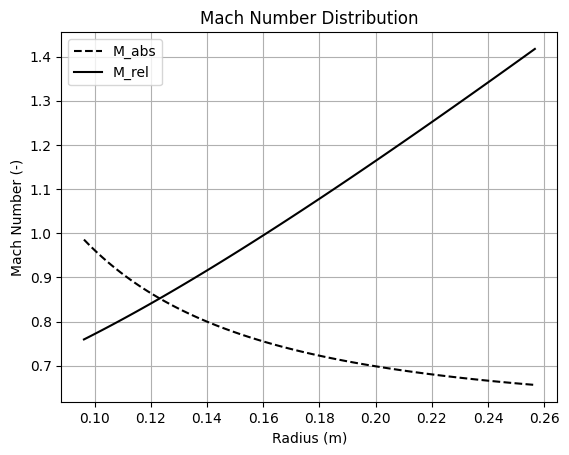

In [ ]:
# Define interactive widgets
radius_slider = widgets.FloatSlider(value=r_midspan, min=r_hub, max=r_tip, step=0.01, description=r'radius R (m)')

# Layout of widgets
topRow = widgets.HBox([radius_slider])

# Create HTML widget (will be updated dynamically)
textBox = widgets.HTMLMath(value="")

# Callback to update the HTML box when sliders change
def UpdateText(r):
	# Calculate local parameters at radius r
	b1, a2, b2 = calculateBladeAngles(r)
		
	# Absolute Mach number: M_abs = c / a, where c = sqrt(c_ax^2 + c_theta^2)
	c_theta_local = A2 / r
	c_abs = np.sqrt(c_ax**2 + c_theta_local**2)
	a_sound = np.sqrt(kappa * R_gas * T)  # speed of sound at inlet static temperature
	M_abs = c_abs / a_sound
	
	# Relative Mach number: M_rel = w / a, where w = sqrt(w_ax^2 + w_theta^2)
	# w_ax = c_ax (constant), w_theta = c_theta - U
	w_1 = np.sqrt(c_ax**2 + U(r)**2)
	M_rel = w_1 / a_sound
	
	# Format as HTML
	text = (
		f"Calculated parameters at r = {r:.3f} m:<br>"
		f"<ul>"
		f"<li>Blade speed U: {U(r):.2f} m/s</li>"
		f"<li>Axial velocity c<sub>x</sub>: {c_ax:.2f} m/s</li>"
		f"<li>Velocity angles: β₁ = {np.degrees(b1):.2f}°, α₂ = {np.degrees(a2):.2f}°, β₂ = {np.degrees(b2):.2f}°</li>"
		f"<li>Flow coefficient φ: {phi(r):.3f} [-]</li>"
		f"<li>Loading factor ψ (local): {psi(r):.3f} [-]</li>"
		f"<li>Degree of reaction R: {degreeOfReaction(r):.3f} [-]</li>"
		f"<li>Absolute Mach number M<sub>abs</sub>: {M_abs:.3f} [-]</li>"
		f"<li>Relative Mach number M<sub>rel</sub>: {M_rel:.3f} [-]</li>"
		f"</ul>"
	)
	textBox.value = text

def PlotAngles(r):

	samples = 50 # Major overhead still comes from matplotlib plotting, not calculations
	radii = np.linspace(r_hub, r_tip, samples)

	b1 = np.zeros(samples)
	a2 = np.zeros(samples)
	b2 = np.zeros(samples)

	for sample in range(samples):
		b1[sample], a2[sample], b2[sample] = calculateBladeAngles(radii[sample])

	# Convert to degrees for plotting
	b1 = np.degrees(b1)
	a2 = np.degrees(a2)
	b2 = np.degrees(b2)

	plt.figure()
	plt.title(f'Velocity Triangles at r = {r:.3f} m')
	plt.grid()
	plt.xlabel('radius r (m)')
	plt.ylabel('angle (degrees)')
	plt.plot(radii, b1 ,label='β₁ (inlet relative)')
	plt.plot(radii, a2, label='α₂ (outlet absolute)')
	plt.plot(radii, b2, label='β₂ (outlet relative)')

	# vertical line at selected radius
	plt.axvline(x=r, color='k', linestyle='--')
	
	# Points at intersected lines
	b1_r, a2_r, b2_r = calculateBladeAngles(r)
	b1_r = np.degrees(b1_r)
	a2_r = np.degrees(a2_r)
	b2_r = np.degrees(b2_r)

	plt.plot(r, b1_r, 'o', color='k')
	plt.plot(r, a2_r, 'o', color='k')
	plt.plot(r, b2_r, 'o', color='k')

	plt.legend()
	plt.xticks()
	plt.yticks()

def PlotVelocityTriangles(r):

	a1 = 0
	b1, a2, b2 = calculateBladeAngles(r)

	# Compatability
	a3 = a1
	b3 = b1

	# set plot bounds
	plt.figure()
	plt.xlim(-220, 550)
	plt.ylim(-650, 500)

	plt.title(f'Velocity Triangles at r = {r:.3f} m')
	# plt.grid()

	# Arrow sizing
	arrowHead = 10

	# Inlet triangles
	inletPos = [250, 400]
	plt.arrow(inletPos[0], inletPos[1], 
		   np.sin(a1) * c_ax, -c_ax, 
		   head_width=arrowHead, head_length=arrowHead, fc='g', ec='g', label='Absolute Velocity')
	plt.arrow(inletPos[0]-(U(r)+arrowHead), inletPos[1] - (c_ax + arrowHead), 
		   U(r), 0, 
		   head_width=arrowHead, head_length=arrowHead, fc='r', ec='r', label='Rotational Velocity')
	plt.arrow(inletPos[0], inletPos[1], 
		   -U(r), -c_ax, 
		   head_width=arrowHead, head_length=arrowHead, fc='b', ec='b', label='Relative Velocity')

	plt.axhline(y = 30, color='k', linestyle='--', linewidth=0.8)
	plt.axhline(y = 120, color='k', linestyle='--', linewidth=0.8)
	plt.text(0, 60 , 'Rotor Stage', fontsize=12)

	# Stage 2 triangles
	stage2Pos = [250, 0]
	w2Deltas = [-np.tan(b2) * c_ax, c_ax]
	plt.arrow(stage2Pos[0], stage2Pos[1],
		   w2Deltas[0], -w2Deltas[1], 
		   head_width=arrowHead, head_length=arrowHead, fc='b', ec='b')
	plt.arrow(stage2Pos[0] + w2Deltas[0], stage2Pos[1] - (c_ax+arrowHead),
		   U(r), 0,
		   head_width=arrowHead, head_length=arrowHead, fc='r', ec='r')
	plt.arrow(stage2Pos[0], stage2Pos[1],
			U(r) + w2Deltas[0], -c_ax,
		   head_width=arrowHead, head_length=arrowHead, fc='g', ec='g')
	
	plt.axhline(y = -250, color='k', linestyle='--', linewidth=0.8)
	plt.axhline(y = -340, color='k', linestyle='--', linewidth=0.8)
	plt.text(0, -320 , 'Stator Stage', fontsize=12)


	# Stage 3 triangles
	stage3Pos = [250, -390]
	plt.arrow(stage3Pos[0], stage3Pos[1],
		   np.sin(a1) * c_ax, -c_ax, 
		   head_width=arrowHead, head_length=arrowHead, fc='g', ec='g')
	plt.arrow(stage3Pos[0]-(U(r)+arrowHead), stage3Pos[1] - (c_ax +arrowHead),
		   U(r), 0, 
		   head_width=arrowHead, head_length=arrowHead, fc='r', ec='r')
	plt.arrow(stage3Pos[0], stage3Pos[1], 
		   -U(r), -c_ax, 
		   head_width=arrowHead, head_length=arrowHead, fc='b', ec='b')

	plt.text(-200, 400 , '1', fontsize=12)
	plt.text(-200, -50 , '2', fontsize=12)
	plt.text(-200, -390 , '3', fontsize=12)
	
	legend = plt.legend(['Absolute Velocity', 'Rotational Velocity', 'Relative Velocity'])
	legend.get_frame().set_alpha(0)

def plotParameters(r):
	
	samples = 50 # Major overhead still comes from matplotlib plotting, not calculations
	radii = np.linspace(r_hub, r_tip, samples)
	psi_values = np.zeros(samples)
	phi_values = np.zeros(samples)
	degree_of_reaction_values = np.zeros(samples)

	for sample in range(samples):
		psi_values[sample] = psi(radii[sample])
		phi_values[sample] = phi(radii[sample])
		degree_of_reaction_values[sample] = degreeOfReaction(radii[sample])

	plt.figure()
	plt.title(f'Parameters at r = {r:.3f} m')
	plt.grid()
	plt.xlabel('radius r (m)')
	plt.ylabel('Parameter (-)')
	plt.plot(radii, psi_values ,label='ψ (flow coefficient)')
	plt.plot(radii, phi_values, label='φ (velocity ratio)')
	plt.plot(radii, degree_of_reaction_values, label='Degree of Reaction')

	# vertical line at selected radius
	plt.axvline(x=r, color='k', linestyle='--')

	plt.plot(r, psi(r), 'o', color='k')
	plt.plot(r, phi(r), 'o', color='k')
	plt.plot(r, degreeOfReaction(r), 'o', color='k')

	plt.legend()
	plt.xticks()
	plt.yticks()

out_text = widgets.interactive_output(UpdateText, 
									  {'r': radius_slider})

out_plot = widgets.interactive_output(PlotAngles,
									  {'r': radius_slider})

outArrows = widgets.interactive_output(PlotVelocityTriangles,
									  {'r': radius_slider})
outParams = widgets.interactive_output(plotParameters,
									  {'r': radius_slider})

ui = widgets.VBox([topRow, textBox])
plots = widgets.HBox([out_plot, outArrows, outParams])

display(ui, plots, out_text)

plt.figure()
radii = np.linspace(r_hub, r_tip, 100)
relMach = np.zeros(100)
for i in range(100):
	relMach[i] = ((np.sqrt(c_ax**2 + U(radii[i])**2))/np.sqrt(kappa*R_gas*T))

plt.plot(radii, relMach, label='M_rel', linestyle='-', color='k')
plt.title('Mach Number Distribution')
plt.xlabel('Radius (m)')
plt.ylabel('Mach Number (-)')
plt.grid()
plt.legend()
plt.show()